In [51]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
import common

In [44]:
df = common.load_df("../data/insead", "*.csv")
df["weekday"] = df.index.weekday
df["weekend"] = df.weekday.apply(lambda x: x in (5,6))
df["hour"] = df.index.hour

train = df["2016-06-15":"2016-07-15"]
test = df["2016-07-16":"2016-08"]

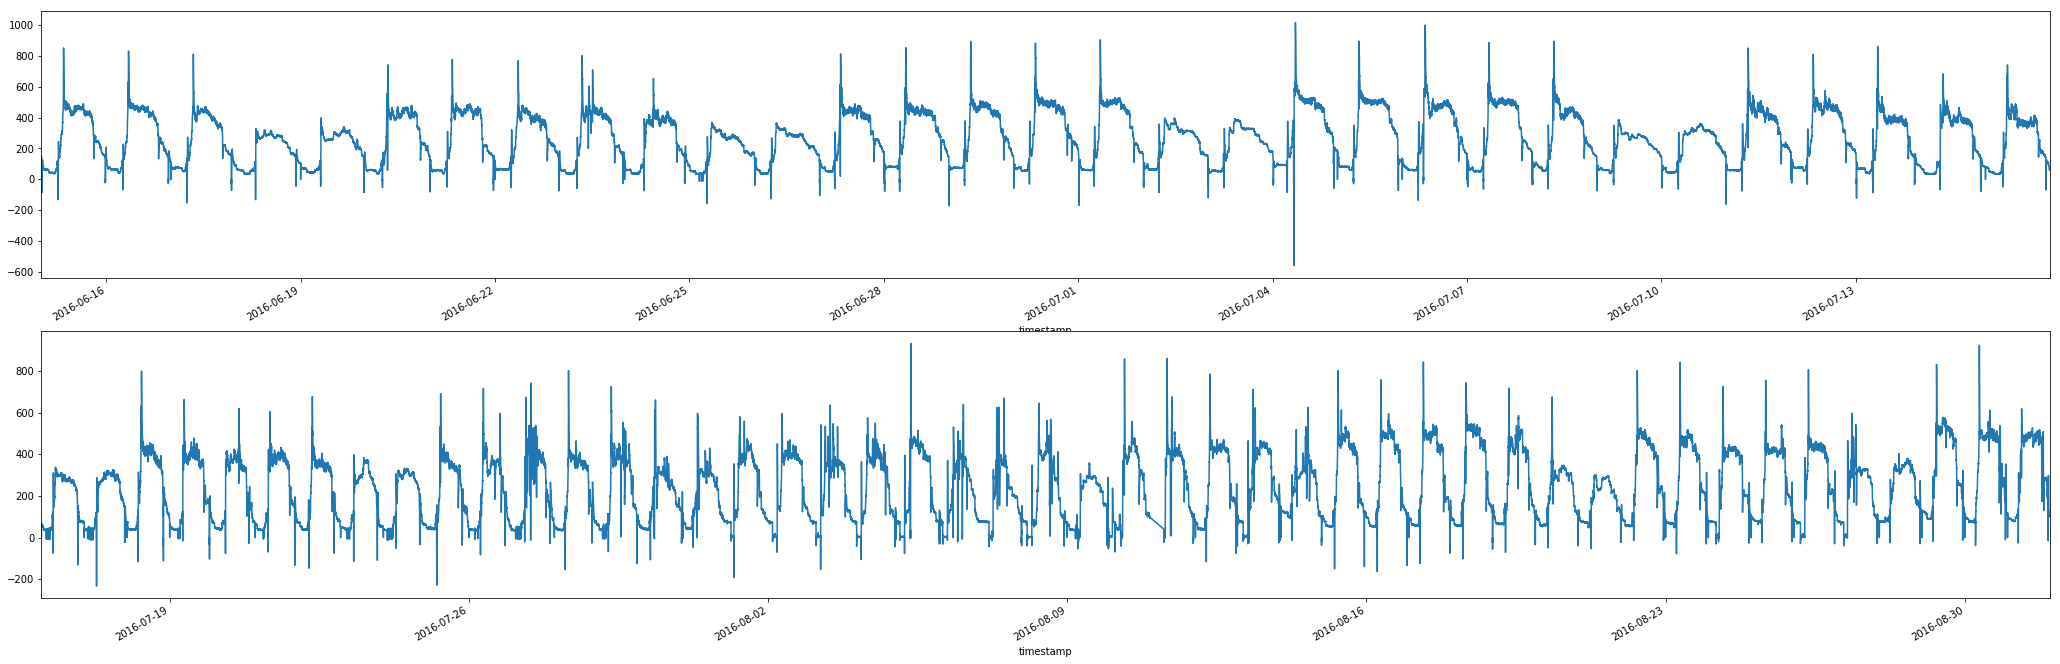

In [22]:
fig, ax = plt.subplots(2,1,figsize=(36,12))
train.loadsys.plot(ax=ax[0])
test.loadsys.plot(ax=ax[1])

In [45]:
features = ["drybulb", "rh", "hour", "weekday", "weekend"]
target = ["loadsys"]

In [95]:
diff.to_csv("../output/diff.csv", index_label="timestamp")

In [94]:
for i,c1 in enumerate(["drybulb", "rh", "hour", "weekday", "weekend", "loadsys"]):
    for j,c2 in enumerate(["drybulb", "rh", "hour", "weekday", "weekend", "loadsys"]):
        if c1 != c2 and i < j:
            col = "{}_{}".format(c1, c2)
            diff[col] = diff[c1] ** 2 + diff[c2] ** 2

(0.4, 0.6)

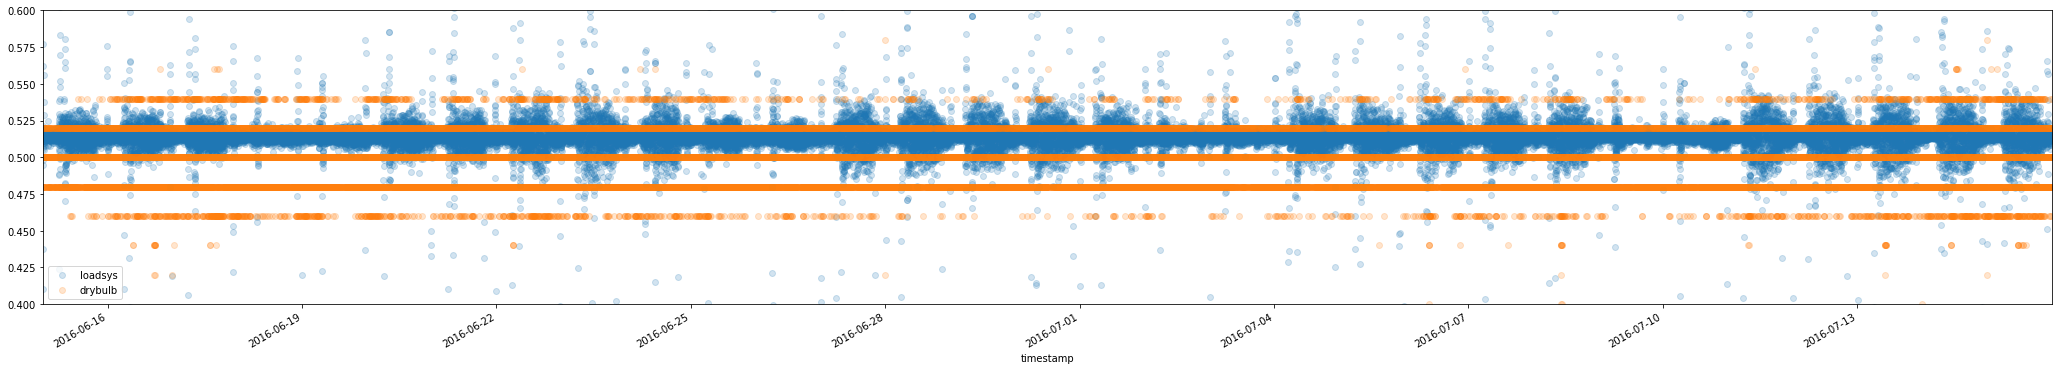

In [93]:
# rate of change of (drybulb & loadsys) vs. time.
diff = train - train.shift(1)
diff -= diff.min()
diff /= diff.max()
ax=diff[["loadsys", "drybulb"]].plot(figsize=(36,6), alpha=.2, style="o")
ax.set_ylim(.4,.6)